# Task:
(Context: Conv2D NN with MNIST digit dataset)

See what leyars do and what sequential model does

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
from matplotlib import pyplot as plt
from keras.datasets import mnist
import tensorflow as tf
import os
import numpy as np
import random

SEED = 0


def set_seeds(seed=SEED):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)


def set_global_determinism(seed=SEED):
    set_seeds(seed=seed)

    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

    tf.config.threading.set_inter_op_parallelism_threads(1)
    tf.config.threading.set_intra_op_parallelism_threads(1)


set_global_determinism(seed=SEED)

def sig(x):
    return 1 / (1+np.exp(-x))


def antisig(x):
    return np.log(-(x/(x-1)))


def show(sets, cols=16, rows=8, negate=False, cmap='gray'):
    fig = plt.figure(figsize=(cols, rows))
    gs = fig.add_gridspec(rows, cols, hspace=0, wspace=0)
    a = gs.subplots()
    a: list[plt.Axes] = a.flatten()
    toplot = 1 - sig(sets) if negate else sets
    for i in range(len(sets)):
        a[i].imshow(toplot[i], cmap=cmap)
    for ax in a:
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()


(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train / 255
x_test = x_test / 255

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)


(60000, 28, 28)
(10000, 28, 28)
(60000,)
(10000,)


In [2]:
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)

print(x_train.shape)
print(x_test.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


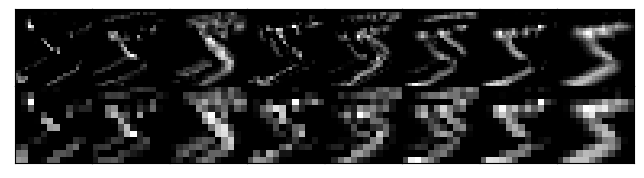

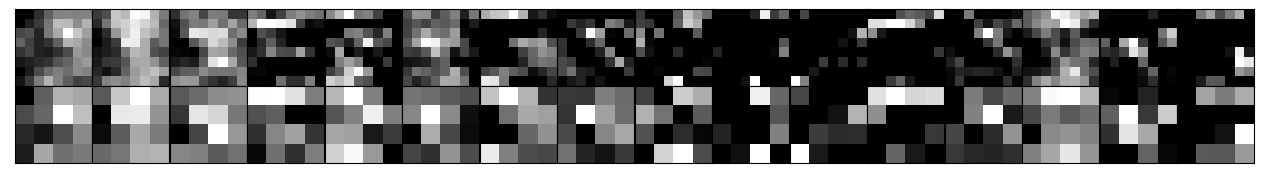

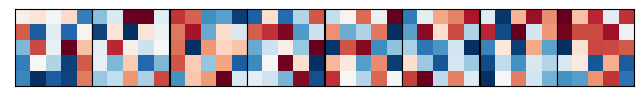

In [3]:
set_seeds(seed=SEED)
F1 = 8
L1 = tf.keras.layers.Conv2D(
    filters=F1,
    kernel_size=5,
    # strides=1,
    activation=tf.keras.activations.relu,
    # kernel_initializer=tf.keras.initializers.VarianceScaling(),
    input_shape=(28,28,1)
)
O1 = L1(x_train[0:1])
L2 = tf.keras.layers.MaxPool2D(
    pool_size=(2, 2),
    strides=(2, 2),
)
O2 = L2(O1)
F3 = 16
L3 = tf.keras.layers.Convolution2D(
    filters=F3,
    kernel_size=5,
    # strides=1,
    activation=tf.keras.activations.relu,
    # kernel_initializer=tf.keras.initializers.VarianceScaling(),
    input_shape=(12, 12, F3)
)
O3 = L3(O2)
L4 = tf.keras.layers.MaxPooling2D(
    pool_size=(2, 2),
    strides=(2, 2)
)
O4 = L4(O3)
L5 = tf.keras.layers.Flatten(input_shape=(4, 4, F3))
O5 = L5(O4)
L6 = tf.keras.layers.Dense(
    units=128,
    activation=tf.keras.activations.relu
)
O6 = L6(O5)
L7 = tf.keras.layers.Dropout(0.2)
O7 = L7(O6)
L8 = tf.keras.layers.Dense(
    units=10,
    activation='linear',
    # kernel_initializer=tf.keras.initializers.VarianceScaling()
)
O8 = L8(O7)

show(sets=[*[O1[0, :, :, i:i+1] for i in range(F1)], *[O2[0, :, :, i:i+1] for i in range(F1)]], rows=2, cols=F1)
show(sets=[*[O3[0, :, :, i:i+1] for i in range(F3)], *[O4[0, :, :, i:i+1] for i in range(F3)]], rows=2, cols=F3)
W1 = np.array(L1.weights[0])
show([W1[:, :, 0, i] for i in range(8)], cols=8, rows=1, cmap="RdBu_r")


In [4]:
set_seeds(seed=SEED)
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=8,kernel_size=5,activation='relu',input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2),strides=(2, 2)),
    tf.keras.layers.Convolution2D(filters=16,kernel_size=5,activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2),strides=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=128,activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10, activation='linear')
])
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 24, 24, 8)         208       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 12, 12, 8)        0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 16)          3216      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 4, 4, 16)         0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               3

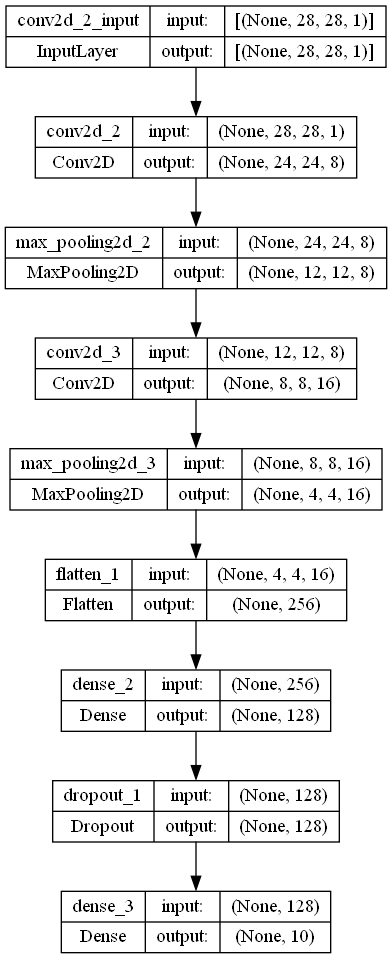

In [5]:
tf.keras.utils.plot_model(
    model,
    show_shapes=True,
    show_layer_names=True,
)


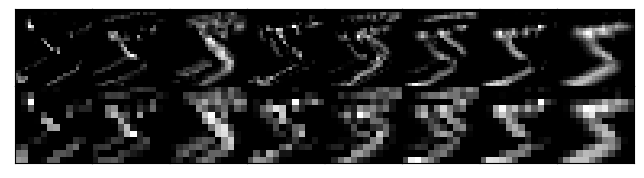

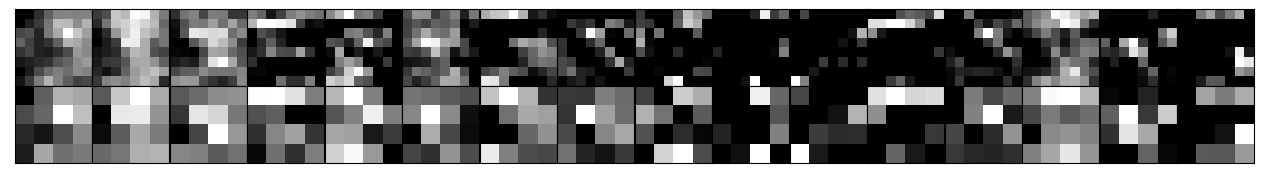

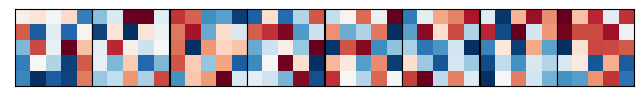

In [6]:
O1_m = model.layers[0](x_train[0:1])
O2_m = model.layers[1](O1_m)
O3_m = model.layers[2](O2_m)
O4_m = model.layers[3](O3_m)
O5_m = model.layers[4](O4_m)
O6_m = model.layers[5](O5_m)
O7_m = model.layers[6](O6_m)
O8_m = model.layers[7](O7_m)
show(sets=[*[O1_m[0, :, :, i:i+1] for i in range(F1)], *[O2_m[0, :, :, i:i+1] for i in range(F1)]], rows=2, cols=F1)
show(sets=[*[O3_m[0, :, :, i:i+1] for i in range(F3)], *[O4_m[0, :, :, i:i+1] for i in range(F3)]], rows=2, cols=F3)
W1_m = np.array(model.weights[0].value())
show([W1_m[:, :, 0, i] for i in range(8)], cols=8, rows=1, cmap="RdBu_r")


In [7]:
model.fit(
    x=x_train,
    y=y_train,
    batch_size=100,
    epochs=10,
    validation_data=(x_test,y_test),
    # verbose=False
)

Epoch 1/10
600/600 [==============================] - 14s 22ms/step - loss: 0.3178 - sparse_categorical_accuracy: 0.9058 - val_loss: 0.0933 - val_sparse_categorical_accuracy: 0.9702
Epoch 2/10
600/600 [==============================] - 12s 20ms/step - loss: 0.0927 - sparse_categorical_accuracy: 0.9715 - val_loss: 0.0502 - val_sparse_categorical_accuracy: 0.9836
Epoch 3/10
600/600 [==============================] - 12s 20ms/step - loss: 0.0663 - sparse_categorical_accuracy: 0.9792 - val_loss: 0.0401 - val_sparse_categorical_accuracy: 0.9874
Epoch 4/10
600/600 [==============================] - 12s 20ms/step - loss: 0.0526 - sparse_categorical_accuracy: 0.9832 - val_loss: 0.0391 - val_sparse_categorical_accuracy: 0.9884
Epoch 5/10
600/600 [==============================] - 12s 20ms/step - loss: 0.0455 - sparse_categorical_accuracy: 0.9862 - val_loss: 0.0349 - val_sparse_categorical_accuracy: 0.9893
Epoch 6/10
600/600 [==============================] - 12s 21ms/step - loss: 0.0383 - spars

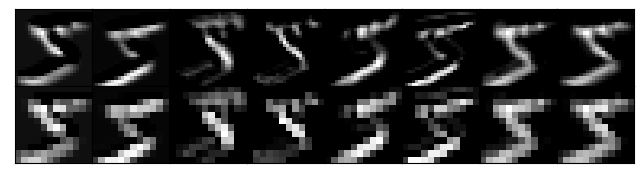

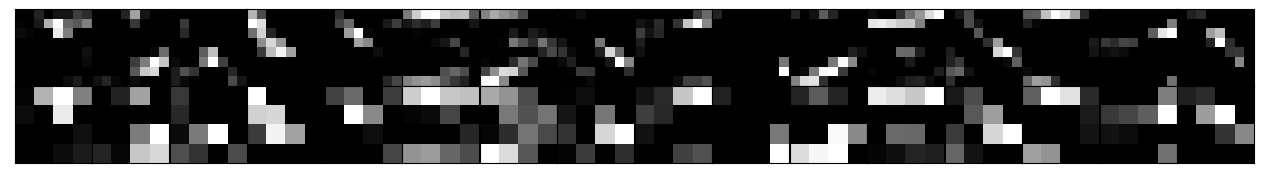

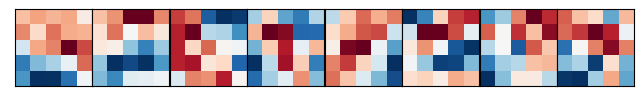

In [8]:
O1_t = model.layers[0](x_train[0:1])
O2_t = model.layers[1](O1_t)
O3_t = model.layers[2](O2_t)
O4_t = model.layers[3](O3_t)
O5_t = model.layers[4](O4_t)
O6_t = model.layers[5](O5_t)
O7_t = model.layers[6](O6_t)
O8_t = model.layers[7](O7_t)
show(sets=[*[O1_t[0, :, :, i:i+1] for i in range(F1)], *[O2_t[0, :, :, i:i+1] for i in range(F1)]], rows=2, cols=F1)
show(sets=[*[O3_t[0, :, :, i:i+1] for i in range(F3)], *[O4_t[0, :, :, i:i+1] for i in range(F3)]], rows=2, cols=F3)
W1_t = np.array(model.weights[0].value())
show([W1_t[:, :, 0, i] for i in range(8)], cols=8, rows=1, cmap="RdBu_r")


In [9]:
y_pred = np.argmax(model.predict(x_test[:100]), axis=-1)
print(y_pred)
print(y_test[:100])
sum(y_pred != y_test[:100])


4/4 [==============================] - 0s 2ms/step
[7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4 9 6 6 5 4 0 7 4 0 1 3 1 3 4 7 2 7
 1 2 1 1 7 4 2 3 5 1 2 4 4 6 3 5 5 6 0 4 1 9 5 7 8 9 3 7 4 6 4 3 0 7 0 2 9
 1 7 3 2 9 7 7 6 2 7 8 4 7 3 6 1 3 6 4 3 1 4 1 7 6 9]
[7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4 9 6 6 5 4 0 7 4 0 1 3 1 3 4 7 2 7
 1 2 1 1 7 4 2 3 5 1 2 4 4 6 3 5 5 6 0 4 1 9 5 7 8 9 3 7 4 6 4 3 0 7 0 2 9
 1 7 3 2 9 7 7 6 2 7 8 4 7 3 6 1 3 6 9 3 1 4 1 7 6 9]


1

Now compare all at once

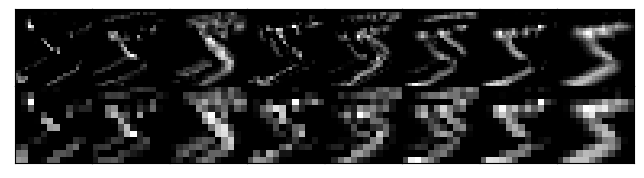

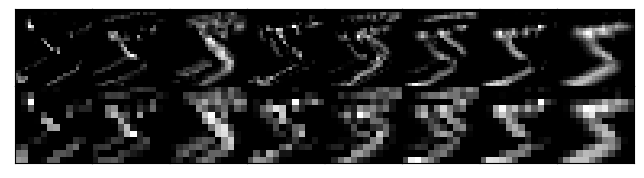

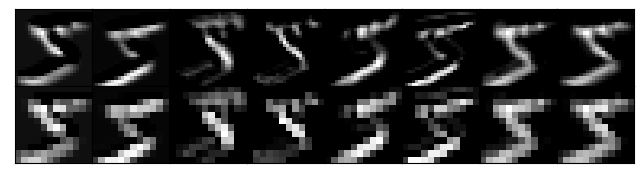

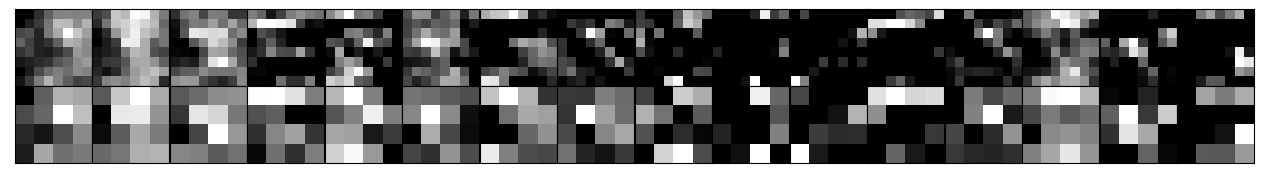

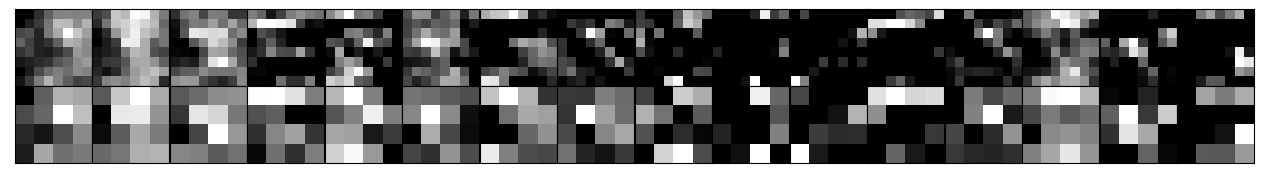

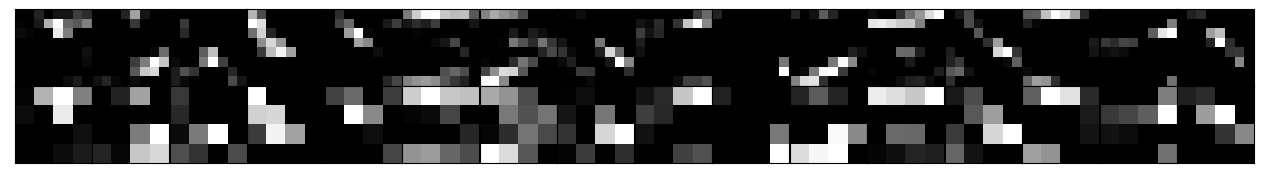

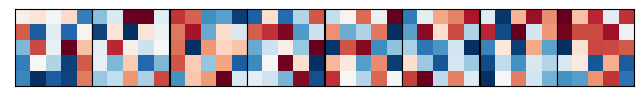

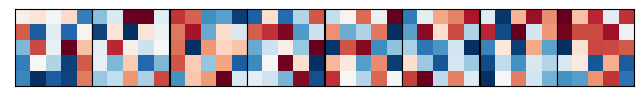

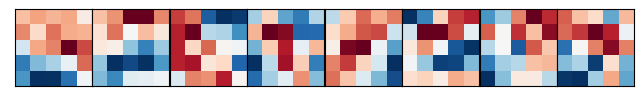

In [10]:

show(sets=[*[O1[0, :, :, i:i+1] for i in range(F1)], *[O2[0, :, :, i:i+1] for i in range(F1)]], rows=2, cols=F1)
show(sets=[*[O1_m[0, :, :, i:i+1] for i in range(F1)], *[O2_m[0, :, :, i:i+1] for i in range(F1)]], rows=2, cols=F1)
show(sets=[*[O1_t[0, :, :, i:i+1] for i in range(F1)], *[O2_t[0, :, :, i:i+1] for i in range(F1)]], rows=2, cols=F1)

show(sets=[*[O3[0, :, :, i:i+1] for i in range(F3)], *[O4[0, :, :, i:i+1] for i in range(F3)]], rows=2, cols=F3)
show(sets=[*[O3_m[0, :, :, i:i+1] for i in range(F3)], *[O4_m[0, :, :, i:i+1] for i in range(F3)]], rows=2, cols=F3)
show(sets=[*[O3_t[0, :, :, i:i+1] for i in range(F3)], *[O4_t[0, :, :, i:i+1] for i in range(F3)]], rows=2, cols=F3)

show([W1[:, :, 0, i] for i in range(8)], cols=8, rows=1, cmap="RdBu_r")
show([W1_m[:, :, 0, i] for i in range(8)], cols=8, rows=1, cmap="RdBu_r")
show([W1_t[:, :, 0, i] for i in range(8)], cols=8, rows=1, cmap="RdBu_r")